# Deep Learning for tensiometry of pendant drop

### Import necessary packages and self-defined classes

In [1]:
# pyplot
import matplotlib.pyplot as plt
# pytorch
import torch
import torch.optim as optim
import torch.nn.functional as F  # useful stateless functions
#Test/Train data split
from functools import lru_cache
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import logging
# sklearn
from sklearn import preprocessing
# os
import os
# warnings
import warnings
warnings.filterwarnings('ignore')
# random
import random

# self-defined model
from model_pic import *
from model_cal import *
import pandas as pd

#PictureNet
from PIL import Image
from skimage.io import imread
from sklearn.model_selection import train_test_split

## Dataset loading and preprocessing

In [2]:
class DataSplit:

    def __init__(self, dataset, test_train_split=0.8, val_train_split=0.1, shuffle=False):
        self.dataset = dataset

        dataset_size = len(dataset)
        self.indices = list(range(dataset_size))
        test_split = int(np.floor(test_train_split * dataset_size))

        if shuffle:
            np.random.shuffle(self.indices)

        train_indices, self.test_indices = self.indices[:test_split], self.indices[test_split:]
        train_size = len(train_indices)
        validation_split = int(np.floor((1 - val_train_split) * train_size))

        self.train_indices, self.val_indices = train_indices[:validation_split], train_indices[validation_split:]

        self.train_sampler = SubsetRandomSampler(self.train_indices)
        self.val_sampler = SubsetRandomSampler(self.val_indices)
        self.test_sampler = SubsetRandomSampler(self.test_indices)
    
    def get_train_split_point(self):
        return len(self.train_sampler) + len(self.val_indices)

    def get_validation_split_point(self):
        return len(self.train_sampler)

    @lru_cache(maxsize=4)
    def get_split(self, batch_size=64, num_workers=0):
        logging.debug('Initializing train-validation-test dataloaders')
        self.train_loader = self.get_train_loader(batch_size=batch_size, num_workers=num_workers)
        self.val_loader = self.get_validation_loader(batch_size=batch_size, num_workers=num_workers)
        self.test_loader = self.get_test_loader(batch_size=batch_size, num_workers=num_workers)
        return self.train_loader, self.val_loader, self.test_loader

    @lru_cache(maxsize=4)
    def get_train_loader(self, batch_size=64, num_workers=0):
        logging.debug('Initializing train dataloader')
        self.train_loader = DataLoader(self.dataset, batch_size=batch_size, sampler=self.train_sampler, shuffle=False, num_workers=num_workers)
        return self.train_loader

    @lru_cache(maxsize=4)
    def get_validation_loader(self, batch_size=64, num_workers=0):
        logging.debug('Initializing validation dataloader')
        self.val_loader = DataLoader(self.dataset, batch_size=batch_size, sampler=self.val_sampler, shuffle=False, num_workers=num_workers)
        return self.val_loader

    @lru_cache(maxsize=4)
    def get_test_loader(self, batch_size=64, num_workers=0):
        logging.debug('Initializing test dataloader')
        self.test_loader = DataLoader(self.dataset, batch_size=batch_size, sampler=self.test_sampler, shuffle=False, num_workers=num_workers)
        return self.test_loader

### Load data for PhysicsNet

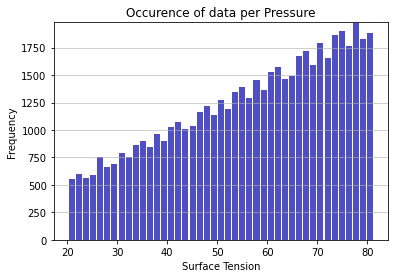

In [17]:
data_matrix = df = pd.DataFrame()

# data_matrix = pd.read_csv("Data_folder/Spline.csv", header= None)           # Spline dataset
data_matrix = pd.read_csv("Big_Data1/Picture_Large.csv", header= None)      # Large dataset (only for observation)

# Make the droplet dataset class based on data_matrix
class Droplet_data_set(Dataset):
    def __init__(self):
        x = data_matrix.iloc[0:,3:].values
        y = data_matrix.iloc[0:,0:2].values

        ###### Data distribution visualization ######
        # x = np.random.normal(x,0.01)
        # y0 is surface tension,  y1 is pressure
        y0 = data_matrix.iloc[:,0].values
        y1 = data_matrix.iloc[:,1].values
        
        # Add normalization for x
        # x = preprocessing.normalize(x)
        # y = preprocessing.normalize(y, axis = 0,norm='l2')
        n, bins, patches = plt.hist(x=y0, bins='auto', color='#0504aa',
                                    alpha=0.7, rwidth=0.85)
        plt.grid(axis='y', alpha=0.75)
        plt.xlabel('Surface Tension')
        # plt.xlabel('Volume[mm^3]')
        plt.ylabel('Frequency')
        plt.title('Occurence of data per Pressure')
        
        maxfreq = n.max()
        # Set a clean upper y-axis limit.
        plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
        ##############################################

        self.x_train = torch.tensor(x,dtype=torch.float32)
        self.y_train = torch.tensor(y,dtype=torch.float32)
        
    def __getitem__(self, idx):
        return self.x_train[idx],self.y_train[idx]
    
    def __len__(self):
         return len(self.y_train)
        
my_data_set = Droplet_data_set()

# Split the single dataset into 3 datasets for training, test and validation.
split = DataSplit(my_data_set, shuffle=True)
train_loader, val_loader, test_loader = split.get_split(batch_size=64, num_workers=0)


### Load data for PictureNet
Read image from files

In [13]:
train_img = []

data_image = pd.read_csv("Data_folder/Spline.csv", header= None)    # Spline dataset
for img_name in data_image.iloc[0:,3:].index + 1:      # modify the number depends on size of dataset
    # defining the image path
    image_path = 'Data_folder/' + str(img_name) + '.png'      # modify the path depends on which dataset
    # reading the image
    img = imread(image_path, as_gray=True)
    img = img[4:-4, 4:-4]  #crop 
    # normalizing the pixel values
    img /= 255.0
    # converting the type of pixel to float 32
    img = img.astype('float32')
    # appending the image into the list
    train_img.append(img)

FileNotFoundError: No such file: 'c:\Users\jrimm\Documents\tue\DL_Pendant_Drop_Tensiometry\Data_folder\1.png'

Plot a single image for viewing

Current image = 69
Picture size = (82, 77)


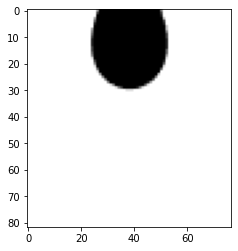

In [28]:
rand = random.randint(0, 112)
print("Current image =", rand)
print("Picture size =", train_img[rand].shape)
plt.imshow(train_img[rand], cmap='gray')

In [30]:
# converting the list to numpy array
train_x_pic = np.array(train_img)
train_y_pic = data_image.iloc[0:,3:].values            # modify the number depends on size of dataset
train_x_pic, rem_x_pic, train_y_pic, rem_y_pic = train_test_split(train_x_pic, train_y_pic, test_size = 0.2)    # default shuffle = True
val_x_pic, test_x_pic, val_y_pic, test_y_pic = train_test_split(rem_x_pic, rem_y_pic, test_size = 0.5)

# converting the trian images and targets into torch format
train_x_pic = train_x_pic.reshape(len(train_x_pic), 1, 82, 77)
train_x_pic  = torch.from_numpy(train_x_pic)
train_y_pic = torch.from_numpy(train_y_pic)
# print(train_x_pic.shape, train_y_pic.shape)

# converting the val images and targets into torch format
val_x_pic = val_x_pic.reshape(len(val_x_pic), 1, 82, 77)
val_x_pic  = torch.from_numpy(val_x_pic)
val_y_pic = torch.from_numpy(val_y_pic)
# print(val_x_pic.shape, val_y_pic.shape)

# converting the test images and targets into torch format
test_x_pic = test_x_pic.reshape(len(test_x_pic), 1, 82, 77)
test_x_pic  = torch.from_numpy(test_x_pic)
test_y_pic = torch.from_numpy(test_y_pic)
# print(test_x_pic.shape, test_y_pic.shape)

# converting the dataset into mini-batch dataset (input 4D -> 5D and 2D -> 3D)
def batch_transform(dataset, batch_size=64):
    batch = []
    batch_num = len(dataset) // batch_size
    for i in range(batch_num+1):
        if len(dataset) == 4:
            if i < batch_num:
                batch.append(dataset[i*batch_size:(i+1)*batch_size, :, :, :])
            else:
                batch.append(dataset[i*batch_size:, :, :, :])
        else:
            if i < batch_num:
                batch.append(dataset[i*batch_size:(i+1)*batch_size, :])
            else:
                batch.append(dataset[i*batch_size:, :])
    return batch

train_x_pic = batch_transform(train_x_pic)
train_y_pic = batch_transform(train_y_pic)
val_x_pic = batch_transform(val_x_pic)
val_y_pic = batch_transform(val_y_pic)
test_x_pic = batch_transform(test_x_pic)
test_y_pic = batch_transform(test_y_pic)
# print(len(train_x_pic), len(train_y_pic), len(val_x_pic), len(val_y_pic), len(test_x_pic), len(test_y_pic))

### Deside to apply host or device


In [31]:
USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
#device = torch.device('cpu')
print(device)

cuda


## Define the functions

In [32]:
def loss_cal_phiysics(loss_list, model, loader):
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        loss_epoch = 0
        for t, (x, y) in enumerate(loader):
            x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float32)
            scores = model(x)
            loss = F.mse_loss(scores, y)
            loss_epoch += loss
        loss_list.append(loss_epoch.cpu().data.numpy()/t)

def loss_cal_picture(loss_list, model, x_dataset, y_dataset):
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        loss_epoch = 0
        for t in range(len(x_dataset)):
            x = x_dataset[t]
            y = y_dataset[t]
            x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float32)
            scores = model(x)
            loss = F.mse_loss(scores, y)
            loss_epoch += loss
        loss_list.append(loss_epoch.cpu().data.numpy()/t)

def prediction(model, x):   # only a batch
    model = model.to(device=device)
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        x = x.to(device=device, dtype=torch.float32)
        score = torch.Tensor.cpu(model(x))
    return score

def train_physics(model, optimizer, epochs=1):
    loss_train = []
    loss_val = []
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for _, (x, y) in enumerate(train_loader):
            x = x.reshape(len(x), 1, 1, -1)     # reshape to 4D data for formal input of model
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float32)
            scores = model(x)
            loss = F.mse_loss(scores, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        loss_cal_phiysics(loss_train, model, train_loader)
        loss_cal_phiysics(loss_val, model, val_loader)
        print('epoch %d: train_loss = %.4f, val_loss = %.4f' % (e+1, loss_train[e], loss_val[e]))
    
    x = range(1, epochs+1)

    plt.semilogy(x, loss_train, 'b-', label="training loss")
    plt.semilogy(x, loss_val, 'r--', label="validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("MSE Loss")
    plt.title("Train/Validation Loss")
    plt.legend()
    plt.show()

def train_picture(model, optimizer, epochs=1):
    loss_train = []
    loss_val = []
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t in range(len(train_x_pic)):
            model.train()  # put model to training mode
            x = train_x_pic[t]
            y = train_y_pic[t]
            x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float32)

            scores = model(x)
            loss = F.mse_loss(scores, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        loss_cal_picture(loss_train, model, train_x_pic, train_y_pic)
        loss_cal_picture(loss_val, model, val_x_pic, val_y_pic)
        print('epoch %d: train_loss = %.4f, val_loss = %.4f' % (e+1, loss_train[e], loss_val[e]))
    
    x = range(1, epochs+1)

    plt.semilogy(x, loss_train, 'b-', label="training loss")
    plt.semilogy(x, loss_val, 'r--', label="validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("MSE Loss")
    plt.title("Train/Validation Loss")
    plt.legend()
    plt.show()


## Train PhysicsNet

epoch 1: train_loss = 1022.8391, val_loss = inf
epoch 2: train_loss = 1020.2399, val_loss = inf
epoch 3: train_loss = 1015.7494, val_loss = inf
epoch 4: train_loss = 977.3696, val_loss = inf
epoch 5: train_loss = 1065.3142, val_loss = inf
epoch 6: train_loss = 1037.0231, val_loss = inf
epoch 7: train_loss = 1000.9583, val_loss = inf
epoch 8: train_loss = 1005.0244, val_loss = inf
epoch 9: train_loss = 1044.3806, val_loss = inf
epoch 10: train_loss = 988.1915, val_loss = inf
epoch 11: train_loss = 1003.5828, val_loss = inf
epoch 12: train_loss = 1033.0867, val_loss = inf
epoch 13: train_loss = 955.9215, val_loss = inf
epoch 14: train_loss = 986.6799, val_loss = inf
epoch 15: train_loss = 936.9997, val_loss = inf
epoch 16: train_loss = 978.6381, val_loss = inf
epoch 17: train_loss = 966.4848, val_loss = inf
epoch 18: train_loss = 977.4803, val_loss = inf
epoch 19: train_loss = 961.9991, val_loss = inf
epoch 20: train_loss = 999.2988, val_loss = inf
epoch 21: train_loss = 1020.9723, val_l

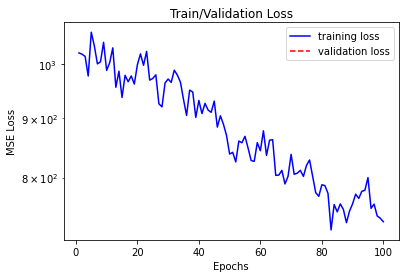

In [33]:
in_channel = 22
node_1 = 512
node_2 = 512
node_3 = 256
node_4 = 256
node_5 = 64
node_6 = 16
out_channel = 2

learning_rate = 1e-3

model_physics = PhysicsNet(in_channel, node_1, node_2, node_3, node_4, node_5, node_6, out_channel)
optimizer = optim.Adam(model_physics.parameters(), lr=learning_rate)
epoch = 100

train_physics(model_physics, optimizer, epoch)
PATH_CAL = os.path.join(os.getcwd(), "model_cal")
torch.save(model_physics, PATH_CAL)


### Visualization of outcomes

In [36]:
PATH_CAL = os.path.join(os.getcwd(), "model_cal")
model_physics_trained = torch.load(PATH_CAL)

examples = enumerate(test_loader)
_, (x_test_example, y_test_example) = next(examples)

score_example = prediction(model_physics_trained, x_test_example)
# y = data_matrix.iloc[0:,0:2].values
#Revert normalized values back to real values
# Print only 8 data samples for comparison
print("Ground Truths =", y_test_example[:15])
print("Prediction    =", score_example[:15].reshape(15, 2))

Ground Truths = tensor([[33., 15.],
        [33., 14.],
        [30., 12.],
        [31., 12.],
        [35., 14.],
        [25., 12.],
        [27.,  8.],
        [16.,  6.],
        [17.,  6.],
        [25.,  9.],
        [16.,  7.],
        [21., 10.],
        [31.,  8.],
        [21.,  9.],
        [38., 16.]])
Prediction    = tensor([[6.0144, 5.1320],
        [5.6872, 4.5889],
        [5.0920, 3.5232],
        [5.1143, 3.5141],
        [5.6895, 4.4482],
        [3.7984, 3.3306],
        [0.5443, 0.3314],
        [0.3235, 0.2814],
        [0.3404, 0.2780],
        [4.1279, 2.7801],
        [0.2587, 0.4283],
        [0.2922, 0.6499],
        [2.0957, 1.3525],
        [0.4639, 0.4175],
        [6.3266, 5.4214]])


## Train PictureNet

epoch 1: train_loss = 1.4457, val_loss = inf
epoch 2: train_loss = 0.5446, val_loss = inf
epoch 3: train_loss = 0.2675, val_loss = inf
epoch 4: train_loss = 0.9754, val_loss = inf
epoch 5: train_loss = 1.6233, val_loss = inf
epoch 6: train_loss = 0.3527, val_loss = inf
epoch 7: train_loss = 0.9578, val_loss = inf
epoch 8: train_loss = 1.2650, val_loss = inf
epoch 9: train_loss = 0.7216, val_loss = inf
epoch 10: train_loss = 2.9798, val_loss = inf
epoch 11: train_loss = 2.2417, val_loss = inf
epoch 12: train_loss = 2.0959, val_loss = inf
epoch 13: train_loss = 3.0929, val_loss = inf
epoch 14: train_loss = 1.0174, val_loss = inf
epoch 15: train_loss = 2.2069, val_loss = inf
epoch 16: train_loss = 1.7948, val_loss = inf
epoch 17: train_loss = 1.2330, val_loss = inf
epoch 18: train_loss = 2.0502, val_loss = inf
epoch 19: train_loss = 1.2349, val_loss = inf
epoch 20: train_loss = 1.4285, val_loss = inf
epoch 21: train_loss = 1.4508, val_loss = inf
epoch 22: train_loss = 1.1736, val_loss = i

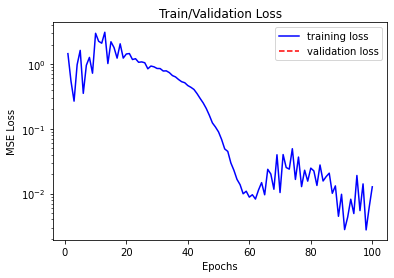

In [37]:
in_channel = 1
channel_1 = 16
channel_2 = 32
channel_3 = 64
node_1 = 1024
node_2 = 1024
out_channel = 22

learning_rate = 1e-3

model_picture = PictureNet(in_channel, channel_1, channel_2, channel_3, node_1, node_2, out_channel)
optimizer = optim.Adam(model_picture.parameters(), lr=learning_rate)
epoch = 100

train_picture(model_picture, optimizer, epoch)
PATH_PIC = os.path.join(os.getcwd(), "model_pic")
torch.save(model_picture, PATH_PIC)

### Visualization of outcomes

In [38]:
# testing cell for better viewing the length
train_x_pic, train_y_pic

print(len(train_x_pic))
print(train_x_pic[0].shape)
print(train_y_pic[0].shape)

2
torch.Size([64, 1, 82, 77])
torch.Size([64, 22])


In [72]:
PATH_PIC = os.path.join(os.getcwd(), "model_pic")
model_picture_trained = torch.load(PATH_PIC)
#Load YC matrix for point values
data_YC = pd.read_csv("Data_folder/YC.csv", header= None)
YC = torch.Tensor(data_YC.values)

rand1 = random.randint(0, len(test_x_pic)-1)
rand2 = random.randint(0, 11)

print("current batch =", rand1)
print("current testing image =", rand2)

score_pic = prediction(model_picture_trained, test_x_pic[0][1].reshape(1, 1, 82, 77))
score_pic = torch.transpose(score_pic[0, 0:11],0,-1)
print(score_pic)
#for num in range(len(test_y_pic[rand1][rand2])):
 #   print(num+1, ": Ground Truths =", test_y_pic[rand1][rand2][num].item(), ", Prediction =", score_pic[0, num].item())


current batch = 0
current testing image = 3
tensor([ 0.6654,  0.4722, -0.1873, -0.1128,  0.1183, -0.0532,  0.0299, -0.0160,
        -0.0777,  0.0653,  0.0051])


### Plot the ground truth and prediction to make a comparison

In [40]:
plt.scatter(test_y_pic[rand1][rand2][0:40], test_y_pic[rand1][rand2][40:80], c="red", label="ground truth")
plt.scatter(score_pic[0, 0:40], score_pic[0, 40:80], c="blue", label="prediction")
plt.xlabel("rr")
plt.ylabel("zz")
plt.legend()
plt.show()

IndexError: index 16 is out of bounds for dimension 0 with size 13